tgb - 5/28/2019 - The goal of this notebook is to develop MSE-ranked diagnostics in the hope to identify climate conditions in which our network performs poorly. What we have so far is the average error for each variable in the md.stats object. The goal is to do the opposite: The climate variable as a function of the error.

# 1) Loading CBRAIN

In [2]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.model_diagnostics import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [3]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [4]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

# 2) Calculate mean of variables conditioned on MSE

## 2.1) Define models

tgb - 5/28/2019 - For now use the best performing LCnet and LACnet

In [36]:
NNa = ['JNNC','JNNL'] # ACnet and LCnet

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,nns in enumerate(NNa):
    path = TRAINDIR+'HDF5_DATA/'+nns+'.h5'
    NN[nns] = load_model(path,custom_objects=dict_lay)
    md[nns] = ModelDiagnostics(NN,config_fn,data_fn)
# # NNL0.01
# path = TRAINDIR+'HDF5_DATA/NNL0.01.h5'
# NN['NNL0.01'] = load_model(path,custom_objects=dict_lay)
# md['NNL0.01'] = ModelDiagnostics(NN,config_fn,data_fn)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


## 2.2) Accumulates all variables over Nt timesteps, with a focus on P-CWV

In [37]:
# User's choice
Nt = 100

P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# Initialization
CWVtot = np.zeros((len(coor.lat),len(coor.lon),1))
QVtot = np.zeros((len(coor.lat),len(coor.lon),len(coor.lev),1))
Ttot = np.copy(QVtot)
CSHtot = np.copy(CWVtot)
xtot = np.zeros((len(coor.lat),len(coor.lon),304,1))
PRECtot = np.zeros((len(coor.lat),len(coor.lon),1))

PREC_NN = {}; MSE_NN = {}; y_NN = {};
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = np.zeros((len(coor.lat),len(coor.lon),1))
    MSE_NN[NNname] = np.copy(PREC_NN[NNname])
    y_NN[NNname] = np.zeros((len(coor.lat),len(coor.lon),218,1))

for itime in range(Nt):
    print('itime=',itime,'/',Nt-1,end="\r")
    m = md[NNname] # Reference model diagnostic object
    # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
    X, truth = m.valid_gen[itime]
    PRECIP = (np.sum(truth.values[:,-4:-2],axis=1))*P_CONV/(L_V*RHO_L)
    # 2) Save mean input
    xgeo = m.reshape_ngeo(m.valid_gen.input_transform.inverse_transform(X).values)
    xtot = np.concatenate((xtot,np.expand_dims(xgeo[:,:,:],axis=3)),axis=3)
    # 3) Water vapor
    QV = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('QBP')]
    QVgeo = m.reshape_ngeo(QV.values)
    QVtot = np.concatenate((QVtot,np.expand_dims(QVgeo[:,:,:],axis=3)),axis=3)
    CWVgeo = m.reshape_ngeo(np.expand_dims(np.sum(m.dP(itime)*QV/G,axis=1),axis=1))
    CWVtot = np.concatenate((CWVtot,CWVgeo[:,:,:][:,:,:]),axis=2)
    # 4) Precipitation
    PRECgeo = m.reshape_ngeo(PRECIP)
    PRECtot = np.concatenate((PRECtot,PRECgeo[:,:,:][:,:,:]),axis=2)
    # 5) Temperature
    T = m.valid_gen.input_transform.inverse_transform(X)[:,m.get_input_var_idx('TBP')]
    Tgeo = m.reshape_ngeo(T.values)[:,:,:]
    Ttot = np.concatenate((Ttot,np.expand_dims(Tgeo[:,:,:],axis=3)),axis=3)
    CSHgeo = m.reshape_ngeo(np.expand_dims(np.sum(m.dP(itime)*C_P*T/(L_V*G),axis=1),axis=1))
    CSHtot = np.concatenate((CSHtot,CSHgeo[:,:,:][:,:,:]),axis=2)
    # 5) Precipitation from NN prediction
    for iNN,NNname in enumerate(NNa):
        pred = md[NNname].model[NNname].predict_on_batch(X)
        PRECIP_NN = (np.sum(pred[:,-4:-2],axis=1))*P_CONV/(L_V*RHO_L)
        PREC_NN[NNname] = np.concatenate((
            PREC_NN[NNname],
            md[NNname].reshape_ngeo(PRECIP_NN)[:,:,:][:,:,:]),
            axis=2)
        y_NN[NNname] = np.concatenate((
            y_NN[NNname],
            md[NNname].reshape_ngeo((pred-truth.values)**2)[:,:,:][:,:,:,np.newaxis]),
            axis=3)
        MEANSE_NN = np.sum((pred-truth.values)**2,axis=1)/pred.shape[1]
        MSE_NN[NNname] = np.concatenate((
            MSE_NN[NNname],
            md[NNname].reshape_ngeo(MEANSE_NN)[:,:,:][:,:,:]),
            axis=2)

# Remove initial zero
QVtot = QVtot[:,:,:,1:]
Ttot = Ttot[:,:,:,1:]
CWVtot = CWVtot[:,:,1:]
CSHtot = CSHtot[:,:,1:]
PRECtot = PRECtot[:,:,1:]
xtot = xtot[:,:,:,1:]
for iNN,NNname in enumerate(NNa):
    PREC_NN[NNname] = PREC_NN[NNname][:,:,1:]
    MSE_NN[NNname] = MSE_NN[NNname][:,:,1:]
    y_NN[NNname] = y_NN[NNname][:,:,:,1:]

In [38]:
y_NN[NNname].mean(axis=(0,1,3)).shape

(218,)

In [60]:
rank = np.argsort(y_NN['JNNL'].mean(axis=(0,1,3)))[::-1]
print(rank)
print(y_NN['JNNL'].mean(axis=(0,1,3))[rank])

[214  21  22 215  20  23  24  25  19  26  29  27 111  28  18 110 112 109
  52  51 217 108  50  17 113 107 211  49 114 210  53 115 106  48  54  16
 116 105  76 117  55  77  75  78  79 213 119  80 216 104  74 118 212  81
  15  73 103  82  56  72 142 143 102 144 141  71  47 145  14 101 138 137
 140 136 139  83 134  70 135 100 146 133  57 132  99  93  92 131  84  13
  98 147  69 167 168 172 169 170 130 166 171 165 164  58 148  97 163 162
 129 173 209  59 161 149  85 174 160  96  12 159 175 128  68 176 123 158
 127  94 152 121  46 177 124 179  95 178  91 126 151 153 125  11 120 157
 122 155 154  86  90 156 200  67 187  66 150   7  10 196   1 203 182 208
 207 186  89  64   0  44 206 204 205 194 183  36   9 192  88 188 191 189
  45 190 193   2 195   5 197 202  87 199 201  31   8  43 198  42 181  40
  41 184  38  61  32 185  30  39  65  34  60  35  33  62 180   3  63  37
   6   4]
[3.58962762e+03 2.89627373e+03 2.73849081e+03 2.08702377e+03
 2.08678877e+03 1.68331199e+03 1.63449224e+03 1.46708

Knowing that the networks predicts:  
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
The previous ranking gives the largest sources of error:  
214 = PRECT  
21 = PHQ[21]  
22 = PHQ[22]  
215 = PRECTEND  
20 = PHQ[20]  
23 = PHQ[23] ...  
111 = TPHYSTND[21]  

So we can say that the largest sources of error are by far precipitation and the lower-tropospheric water vapor

In [69]:
print(rank[25:30])

[107 211  49 114 210]


Text(0, 0.5, '$\\textnormal{Mean squared error }\\left(\\mathrm{W^{2}m^{-4}}\\right)$')

<Figure size 800x320 with 0 Axes>

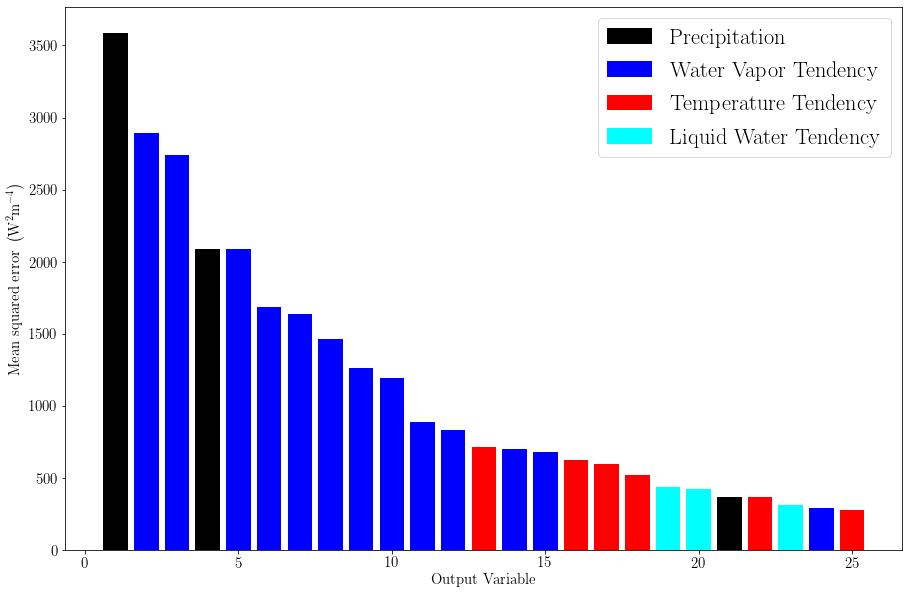

In [96]:
fz = 15
lw = 2
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

f = plt.figure(num=None, figsize=(10,4), dpi=80, facecolor='w', edgecolor='k')
plt.gcf().subplots_adjust(bottom=0.15) # Make room for xlabels

Lowrank = 25 # Show top Lowrank variables
# Doing the variable <-> color manually because it would take too long to make it automatic
plt.figure(figsize=(15,10))
barplt = plt.bar(x=np.linspace(start=1,stop=Lowrank,num=Lowrank),height=y_NN['JNNL'].mean(axis=(0,1,3))[rank][:Lowrank],\
                 color=['black', 'blue', 'blue', 'black', 'blue',\
                        'blue','blue','blue','blue','blue',\
                        'blue','blue','red','blue','blue',\
                        'red','red','red','cyan','cyan',\
                        'black','red','cyan','blue','red'])
plt.legend((barplt[0],barplt[1],barplt[12],barplt[19]),\
           ('Precipitation','Water Vapor Tendency','Temperature Tendency','Liquid Water Tendency'),\
           fontsize=1.5*fz)
plt.xlabel('Output Variable')
plt.ylabel(r'$\textnormal{Mean squared error }\left(\mathrm{W^{2}m^{-4}}\right)$')

In [97]:
# First use column water vapor as binning variable to test
# Histogram parameters
Nbin = 100
CWVmin = 20
CWVmax = 70
# Initialization
CWVm = np.zeros((Nbin-1,1))
CSHm = np.copy(CWVm)
Pm = np.copy(CWVm)

PNNm = {}; MSENNm = {};
for iNN,NNname in enumerate(NNa):
    PNNm[NNname] = np.copy(Pm)
    MSENNm[NNname] = np.copy(Pm)

for ibin,edge in enumerate(np.linspace(CWVmin,CWVmax,num=Nbin)):
    print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
    if ibin>0:
        CWVm[ibin-1] = np.average(CWVtot,weights=(CWVtot>=edge_left)*(CWVtot<edge))
        Pm[ibin-1] = np.average(PRECtot,weights=(CWVtot>=edge_left)*(CWVtot<edge))
        CSHm[ibin-1] = np.average(CSHtot,weights=(CWVtot>=edge_left)*(CWVtot<edge))
        for iNN,NNname in enumerate(NNa):
            PNNm[NNname][ibin-1] = np.average(
                PREC_NN[NNname],
                weights=(CWVtot>=edge_left)*(CWVtot<edge))
            MSENNm[NNname][ibin-1] = np.average(
                MSE_NN[NNname],
                weights=(CWVtot>=edge_left)*(CWVtot<edge))
        
    edge_left = edge

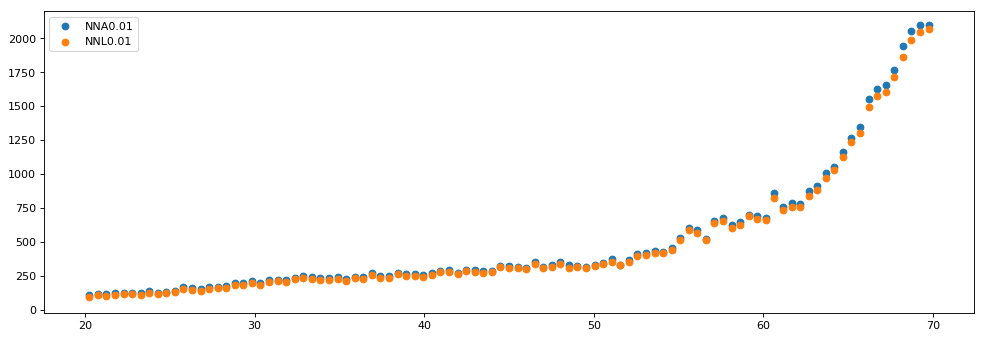

In [8]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
for iNN,NNname in enumerate(NNa):
    plt.scatter(CWVm,MSENNm[NNname],label=NNname)
plt.legend()

tgb - Then flip it and use the MSE as the binning variable

In [99]:
# Model choice
MSEtot = MSE_NN['JNNL']
# Histogram parameters
Nbin = 100
MSEmin = 0
MSEmax = 2e3
# Initialization
CWVm = np.zeros((Nbin-1,1))
CSHm = np.copy(CWVm)
Pm = np.copy(CWVm)
MSEm = np.copy(CWVm)
lattot = np.expand_dims(np.expand_dims(lat.values,axis=1),axis=2)
for i in range(2):
    lattot = np.repeat(lattot,CWVtot.shape[i+1],axis=i+1)
latm = np.copy(CWVm)

for ibin,edge in enumerate(np.linspace(MSEmin,MSEmax,num=Nbin)):
    print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
    if ibin>0:
        CWVm[ibin-1] = np.average(CWVtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        Pm[ibin-1] = np.average(PRECtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        CSHm[ibin-1] = np.average(CSHtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        MSEm[ibin-1] = np.average(MSEtot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        latm[ibin-1] = np.average(lattot,weights=(MSEtot>=edge_left)*(MSEtot<edge))
        
    edge_left = edge

<Figure size 1200x400 with 0 Axes>

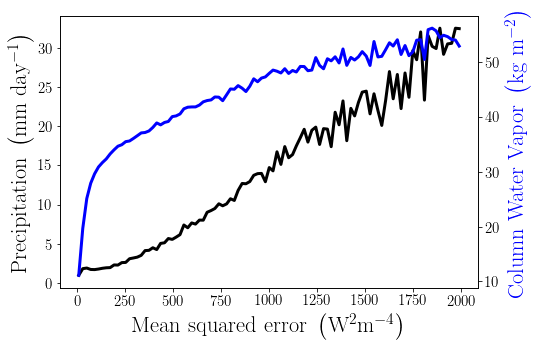

In [113]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = 1.5*lw
plt.close('all')
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots(figsize=(7.5,5))

ax2 = ax1.twinx()
ax1.plot(MSEm,Pm, 'black')
ax2.plot(MSEm,CWVm, 'blue')

ax1.set_xlabel(r'$\textnormal{Mean squared error }\left(\mathrm{W^{2}m^{-4}}\right)$',fontsize=1.5*fz)
ax1.set_ylabel(r'$\textnormal{Precipitation }\left(\mathrm{mm\ day^{-1}}\right)$', color='black',fontsize=1.5*fz)
ax2.set_ylabel(r'$\textnormal{Column Water Vapor }\left(\mathrm{kg\ m^{-2}}\right)$', color='blue',fontsize=1.5*fz)

plt.show()

Text(0, 0.5, 'Expected Latitude')

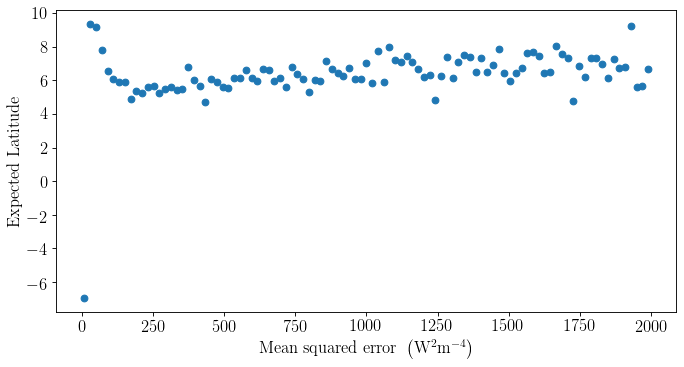

In [115]:
plt.figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,latm)
plt.xlabel(r'$\textnormal{Mean squared error }\left(\mathrm{W^{2}m^{-4}}\right)$')
plt.ylabel('Expected Latitude')

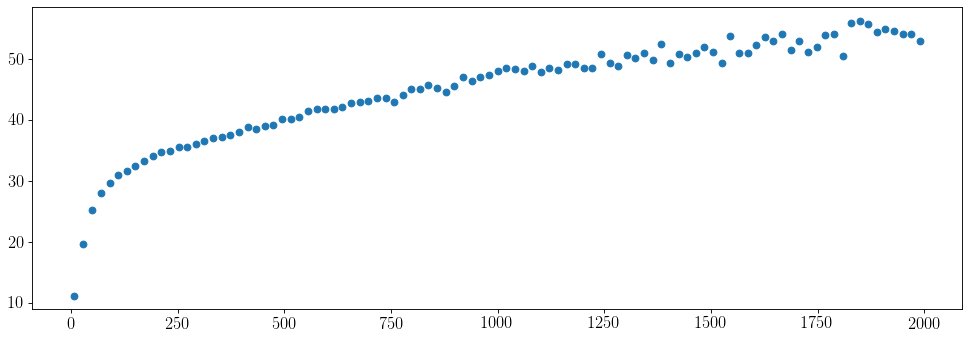

In [103]:
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,CWVm)

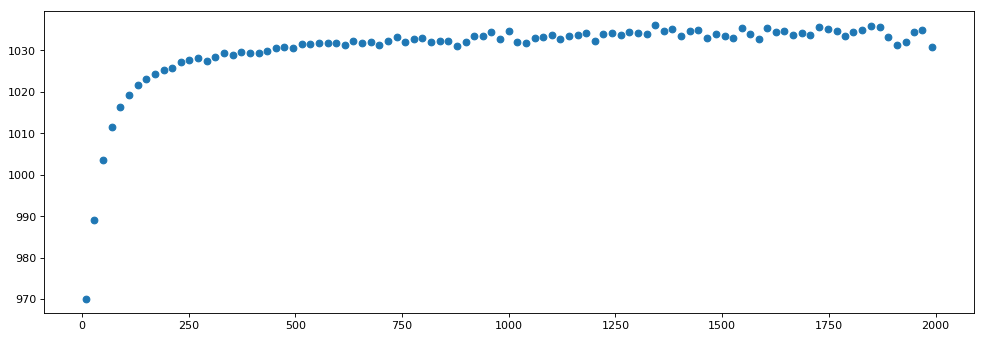

In [13]:
plt.figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(MSEm,CSHm)

In [81]:
lattot = np.expand_dims(np.expand_dims(lat.values,axis=1),axis=2)

In [82]:
lattot.shape

(64, 1, 1)

In [84]:
lattot = np.repeat(lattot,CWVtot.shape[1],axis=1)

In [89]:
lattot.shape

(4096, 1, 100)